<a href="https://colab.research.google.com/github/rmaffulli/MI_tutorial/blob/main/MI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Information Theory in neuroscience
Aims of the tutorial:
- Understand the concept of entropy and quantify entropy in a signal
- Binning strategies
- Define mutual information and calculate it for a Poisson spiking neuron
- Bias: origin, implications and mitigation strategies
- The effect of correlated firing on information transmission

Suggested reading for a deeper understanding of the topics covered in this tutorial:
1. Timme, Nicholas M., and Christopher Lapish. "A tutorial for information theory in neuroscience." eneuro 5.3 (2018).
1. Quiroga, R. Q., & Panzeri, S. (2009). Extracting information from neuronal populations: information theory and decoding approaches. Nature Reviews Neuroscience, 10(3), 173-185.
1. Averbeck, B., Latham, P. & Pouget, A. Neural correlations, population coding and computation. Nat Rev Neurosci 7, 358–366 (2006). https://doi.org/10.1038/nrn1888 and references.

---
# Setup

In [2]:
#@title Import
import numpy as np
import random as rnd
from matplotlib import pyplot as plt
from scipy.stats import poisson

rnd.seed(2020)

In [3]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/rmaffulli/MI_tutorial/main/figures.mplstyle")

---
# Generation of Poisson spikes
We know that spikes are binary discrete events.
It is often assumed, in first approximation, that each spike is independent of the previous/following one. This implies that the probability of having a spike at a certain time is not influenced by the probability that a spike has occurred previously. This *model* (beware! this is a model the behaviour of a neuron) is consistent with a spike event to be drawn from a Poisson distribution.

*Food for toughts: what are the mechanisms that invalidate the Poisson assumption? Can we think of some reasons to doubt that a spiking neuron is Poissonian?*

In the cell below you can explore the function generating poissonian spike trains.

In [4]:
#@title Spike generation function
def poisson_spike(t,rate):
  # t: time points
  # rate: spiking rate in Hz
  dt = t[1] - t[0];
  sp = np.zeros_like(t)
  for i,tp in enumerate(t):
    if rnd.uniform(0,1) <= dt*rate:
      sp[i] = 1
  
  return sp

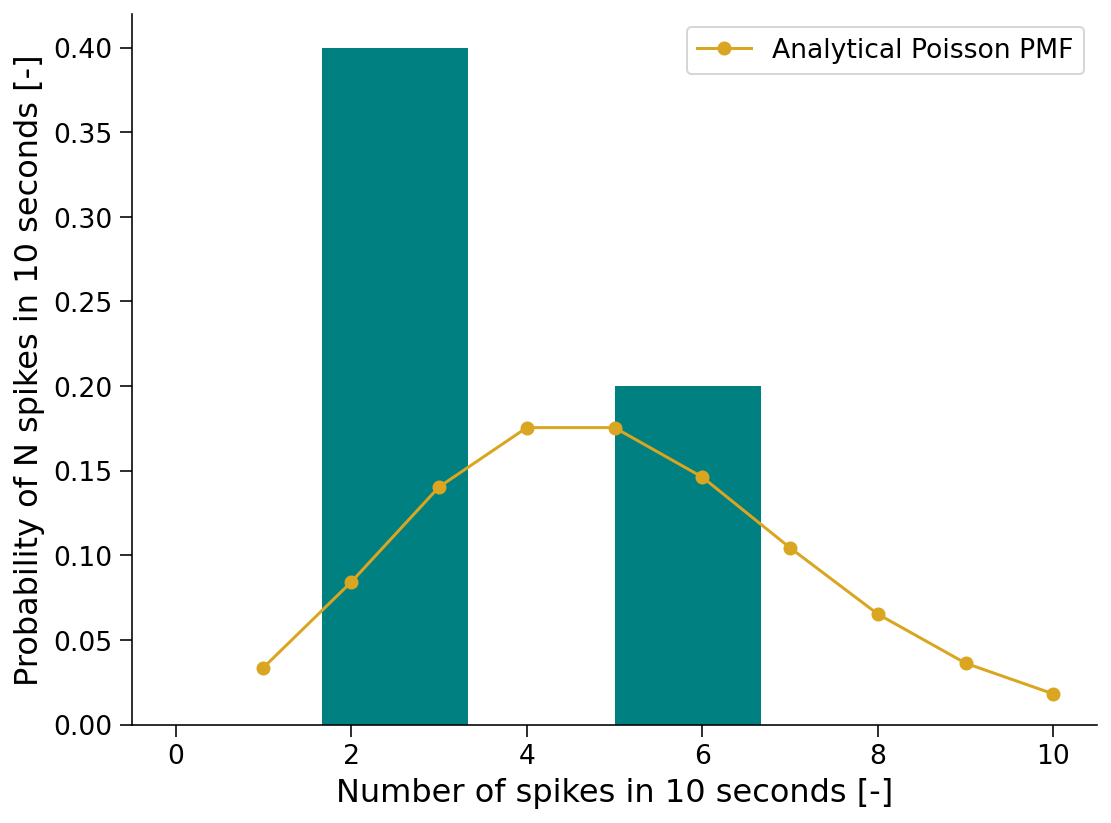

In [5]:
#@title The effect of the number of trials on estimation of probabiltiy mass function { run: "auto" }
trials = 3 #@param {type:"slider", min:1, max:1000, step:1}
rate = 0.5 #@param {type:"slider", min:0.1, max:10, step:0.1}

spike_cnt = np.zeros((trials,))

t = np.linspace(0,10,1000)
for tr in range(trials):
  sp = poisson_spike(t,rate)
  spike_cnt[tr-1] = sum(sp)

_ = plt.hist(spike_cnt,
             range=(0, 2*int(spike_cnt.max())),
             bins=int(spike_cnt.max() + 1),
             density=True, histtype='stepfilled',
             color='teal', edgecolor='none')
x_poisson = np.linspace(1,2*int(spike_cnt.max()),2*int(spike_cnt.max()))
_ = plt.plot(x_poisson, poisson.pmf(x_poisson, rate*10),
             '-o', label='Analytical Poisson PMF',
            color='goldenrod')
plt.xlabel('Number of spikes in 10 seconds [-]')
plt.ylabel('Probability of N spikes in 10 seconds [-]')
_ = plt.legend()

---
# Entropy of a random variable
In this section we will:
- Learn how to calculate the entropy of a random variable
- Understand how the probability distribution of such random variable influences its entropy

Given a Random Variable (RV) $R$, its entropy is defined as:

$H(R) = \sum\limits_{r\in X}p(x)log_2\frac{1}{p(x)}$

in the section below we will implement the following functions:

- `def marginal_p(x):` to calculate the marginal probability of a RV $X$
- `def entropy(x):` to calculate the entropy of $(X)$

In [6]:
def marginal(x):
  # returns marginal probabiltiy of random variable X based on observations x
  # x is a 2d matrix: rows are the trials, columns are the response values (considers multi-dimensional responses)
  # find unique values of x and count the number of occurrences across trials
  x_values, p_x = np.unique(x, axis=0, return_counts=True)
  # calculate probabilities of each occurrences
  p_x = p_x/np.shape(x)[0]
  # return probability vector
  return p_x, x_values


def entropy(x):
  # returns entropy of random variable X
  # x is a 2d matrix: rows are the trials, columns are the response values (considers multi-dimensional responses)
  # initialize entropy
  ent = 0
  # calculate marginal probability
  p_x, x_values = marginal(x)
  # calculate entropy
  for x_i,p in zip(x_values,p_x):
    ent += p*np.log2(1/p)
  # return entropy
  return ent

x = np.asarray([[0, 1],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1]])
print(entropy(x))
if entropy(x) == 1:
  print("Correct! the value of entropy(x) is: " + str(entropy(x)))
else:
  raise NotImplementedError("Wrong values of entropy, double check the implementation of entropy and marginal functions")

1.0
Correct! the value of entropy(x) is: 1.0


Entropy: 6.257941799661588 [bits]


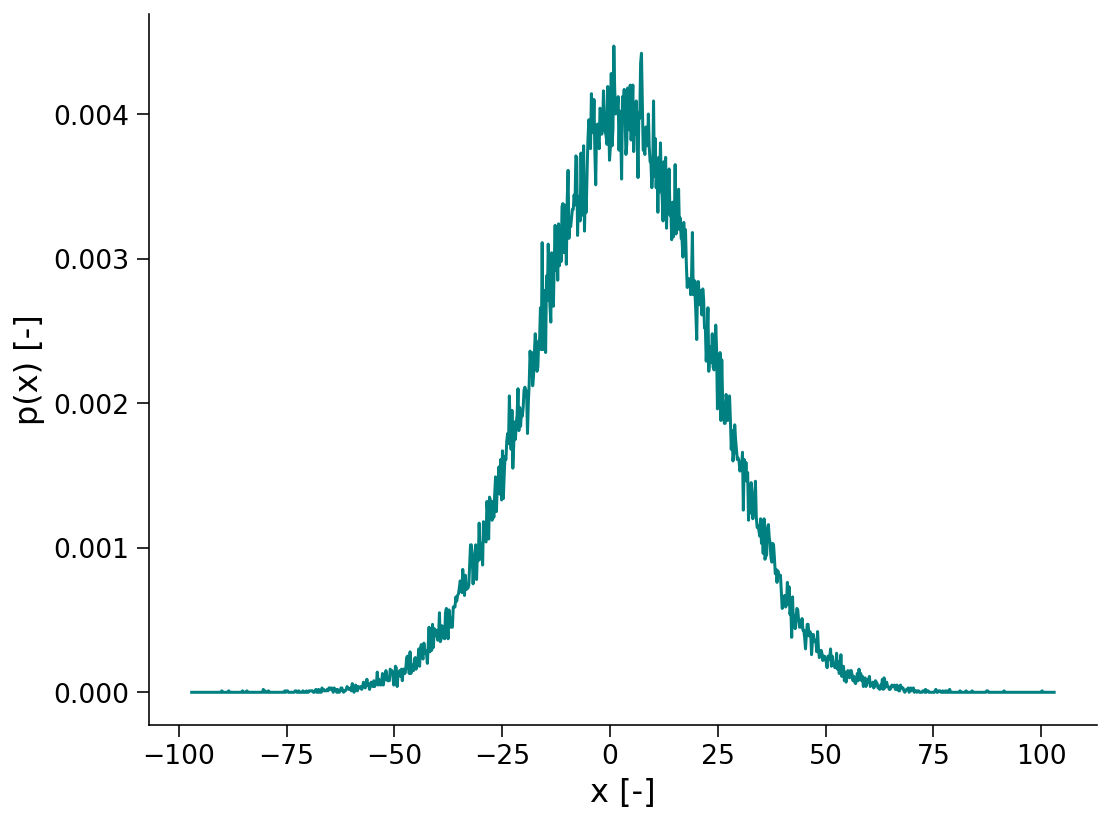

In [88]:
#@title Entropy of a Gaussian random variable { run: "auto" }
mean = 3 #@param {type:"slider", min:-5, max:5, step:1}
std = 20 #@param {type:"slider", min:0.5, max:20, step:0.5}
trials = 100000

x = np.random.normal(mean,std,trials)
bins = np.linspace(mean-100,mean+100,1000)
x_binned = np.zeros_like(bins)
for i in np.digitize(x,bins):
  x_binned[i-1] += 1
p_x = x_binned/sum(x_binned)
_ = plt.plot(bins,p_x,color='teal')
plt.xlabel('x [-]')
plt.ylabel('p(x) [-]')

print("Entropy: " + str(entropy(x_binned)) + " [bits]")

---
# Conditional entropy of two random variables
In this section we will:
- Learn how to calculate the conditional entropy of one random variable X given a second variable Y

In the section below we will implement the following functions:

- `def joint_p(x,y):` to calculate the joint probability of $(X;Y)$
- `def conditional_p(x,y):` to calculate the conditional probability of a $(X|Y)$
- `def conditional_entropy(x,y):` to calculate the conditional entropy of $(X|Y)$

---
# Mutual Information
In this section we will:
- Learn how to calculate the mutual information between signal and response for two Poisson spiking neurons
in the section below we will implement the following functions:

- `def mi(x,y):` to calculate the mutual information of $(X;Y)$

---
# A digression on binning
In this section we will:
- Discuss the effects of number of bins on the calculation of MI
- Consider the difference between binning strategies

---
# Bias and bias correction strategies
In this section we will:
- Demonstrate the effect of bias on the calculation of MI
- Implement quadratic extrapolation for bias correction

---
# Effect of noise correlations in population coding
In this section we will:
- Define the response of 2 neurons to 2 different stimuli and see how noise correlations affect their response:
  - Can we build an hypothesis about the effect on noise correlations on information in neuronal populations?
- Discuss the problems arising from looking at multi-dimensional responses
- Confirm/discard our hypothesis on the effect of noise correlations on information in neuronal populations through numerical calculations
